# Capstone 3: *Cancer Gene Expression Classification*
## *Preprocessing, Training, and Modeling*
***

## 2.1 Table of Contents<a id='2.1_Contents'></a>
* [2 Preprocessing, Training, and Modeling](#2_Data_wrangling)
  * [2.1 Table of Contents](#2.1_Contents)
  * [2.2 Introduction](#2.2_Introduction)
  * [2.3 Importing the Dependencies](#2.3_Importing_the_Dependencies)
  * [2.4 Importing the Data](#2.4_Importing_the_Data)
  * [2.5 Choosing the Landing Dimension](#2.5_Choosing_the_Landing_Dimension')
  * [2.6 Choosing the Primary Performance Metric](#2.6_Choosing_the_Primary_Performance_Metric)
  * [2.7 Baseline Model](2.7_Baseline_Model)
      * [2.7.1 Splitting the Data](#2.7.1_Splitting_the_Data)
      * [2.7.2 Modeling with Logistic Regression](#2.7.2_Modeling_with_Logistic_Regression)
  * [2.8 Overfitting](#2.8_Overfitting)
  * [2.9 Save Data](#2.9_Save_Data)
  * [2.10 Summary](#2.10_Summary)
  

## 2.2 Introduction
<a id='2.2_Introduction'></a>
At this point in the project, the data is clean and ready to use.  I have identified and explored concerns with the large number of dimensions (20532), the lack of variance in 267 columns, the high colinearity (correlation coefficient of 90% or above) for 2254 pairs of features, and the imbalanced data.

I will begin this notebook by addressing dimensional reduction with PCA.  I will then build a baseline model with logistic regression with the data in it's current, imbalanced state, and assess the need to balance the data in extended modeling.

## 2.3 Importing the Dependencies
<a id='2.3_Importing_the_Dependencies'></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.svm import LinearSVC

#pd.set_option('display.max_rows', 70)

## 2.4 Importing the Data
<a id='2.4_Importing_the_Data'></a>

In [2]:
data = pd.read_csv("../source_data/data.csv")
labels = pd.read_csv("../source_data/labels.csv")

In [3]:
data.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [4]:
labels.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


## 2.5 Choosing the Landing Dimension
<a id='2.5_Choosing_the_Landing_Dimension'></a>
For a multi-class classification problem, the rule of thumb is that a dataframe should have at least 10 samples per feature for the smallest class.  In other words, there should be at least ten times more rows than columns.  The dataframe I am using has 801 samples, but the smallest class only has 78.  So, according to the rule of thumb, the number of features should be restricted to 7 or, if I round, 8. I'll take a look at what percentage of variance that level of restriction would represent.  I'll also look at the amount of vaiance explained by 30 features (one tenth of the number of features in the majority class) since this might become valid if oversampling is implemented, 80 features (one tenth of the total number of samples), and I will also find the number of features which would be needed to capture 90% of the variance. 

In [5]:
data = data.drop("Unnamed: 0", axis=1)

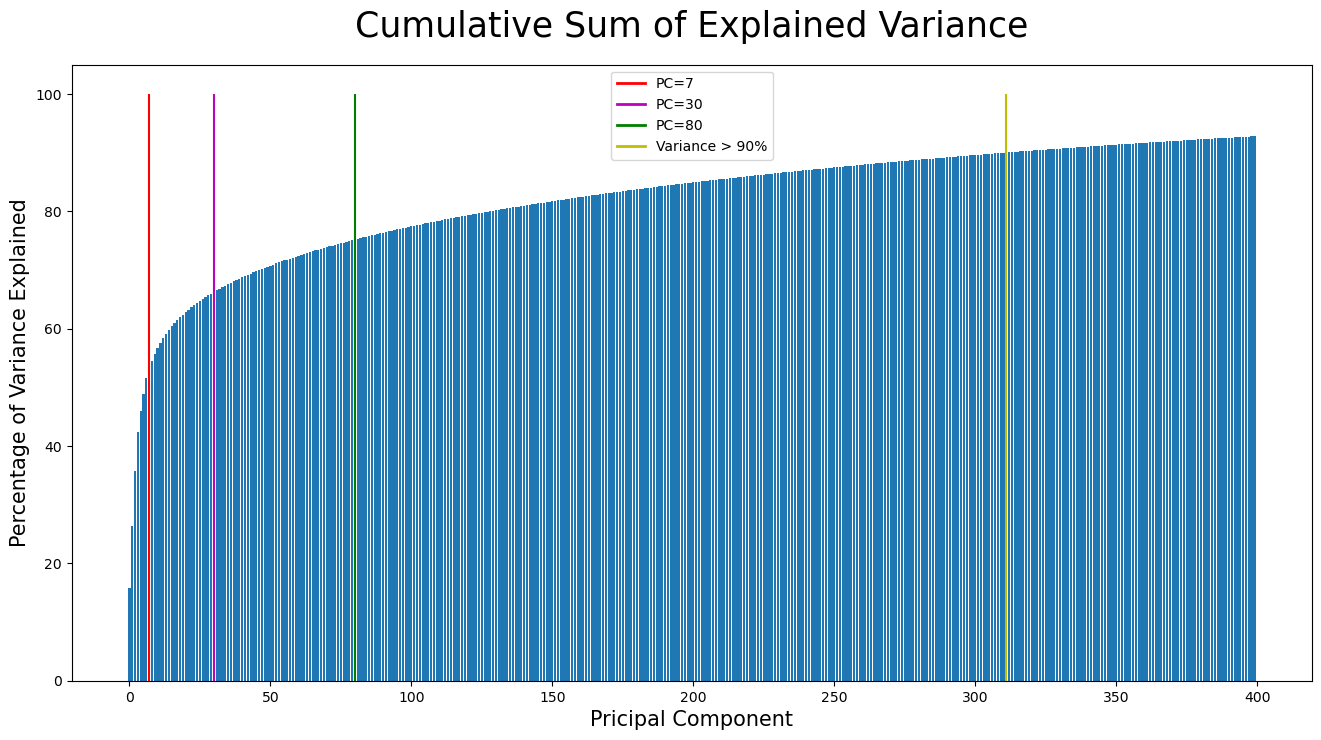

In [6]:
pca = PCA(n_components=400)
pca.fit_transform(data)

cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum_perc=cumsum*100

plt.figure(figsize=(16,8))
plt.bar(range(0,len(cumsum_perc)), cumsum_perc)
plt.title("Cumulative Sum of Explained Variance", fontsize=25, pad=20)
plt.xlabel("Pricipal Component", fontsize=15)
plt.ylabel("Percentage of Variance Explained", fontsize=15)
plt.vlines([7, 30, 80], 0, 100, colors=['r', 'm', 'g'])
plt.vlines([np.where(cumsum_perc>=90)[0][0]], 0,100, colors=['y'])

cust_lines = [Line2D([0], [0], color='r', lw=2),
              Line2D([0], [0], color='m', lw=2),
                Line2D([0], [0], color='g', lw=2),
                Line2D([0], [0], color='y', lw=2)]

plt.legend(cust_lines, ['PC=7', 'PC=30', 'PC=80', 'Variance > 90%'], loc='upper center');

It is interesting to see the different potential landing dimension, but it looks like followng the rule of thumb is likely going to be sufficient for this project.  The percentage of variance explained by each principal component is far less after the red line than before.  I'll take a closer look at the explained variance for the first seven principal components below.

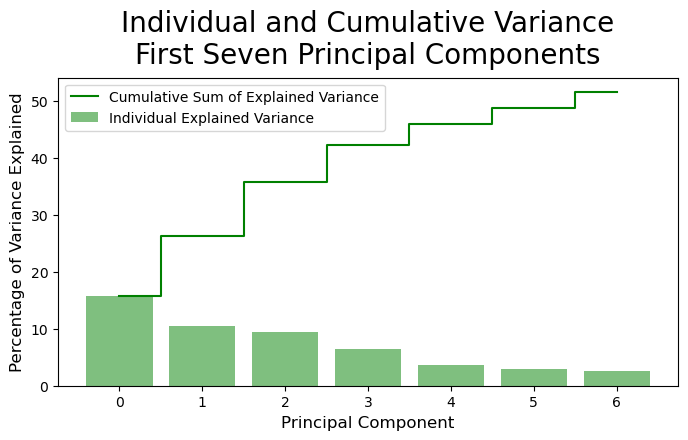

In [7]:
pca = PCA(n_components=7)
pca.fit_transform(data)
    
# Find individual explained variance and then change to percent
exp_var_pca = pca.explained_variance_ratio_
exp_var_pca_perc = exp_var_pca*100

# Find cumulative explained variance and then change to percent
cum_sum = np.cumsum(exp_var_pca)
cum_sum_perc=cum_sum*100

# Plot the individual and cumulative variance results
plt.figure(figsize=(8,4))
plt.bar(range(0,len(exp_var_pca_perc)), exp_var_pca_perc, alpha=0.5, color = 'g', label='Individual Explained Variance')
plt.step(range(0,len(cum_sum_perc)), cum_sum_perc, where='mid',color = 'g', label='Cumulative Sum of Explained Variance')
plt.title('Individual and Cumulative Variance\nFirst Seven Principal Components', pad=10, fontsize=20)
plt.ylabel('Percentage of Variance Explained', fontsize=12)
plt.xlabel('Principal Component', fontsize=12)
plt.legend(loc='best')
plt.show()

#https://vitalflux.com/pca-explained-variance-concept-python-example/ 

## 2.6 Choosing the Primary Performance Metric
<a id='2.6_Choosing_the_Primary_Performance_Metric'></a>
Before I begin modeling, I will need to chose which performance metric to use as my primary indicator of success.  A number of different performance metrics can be useful for evaluating classification problems inlcuding precision, recall, the f1-score, and accuracy as seen above in the classification reports.  

Other useful metrics are the receiver operating characteristics (ROC) Curve, the Precision-Recall Curve, and the areas underneath each of these two.  The ROC Curve plots the true positive rate against the false positive rate, whereas the precision-recall curve plots precision (true positive/(true positive + false positive) against recall (true positive/(true positive + false negative).  

ROC and Precision-Recall Curves are designed to be used with binary classification.  Since I have more than two classes, I would need to binarize (one verses all) my output and then look at the curve for each class separately.  

An alternative would be to use the ROC-AUC score.  When one-vs-the-rest (OvR) is selected, this gives a single numerical value for the area under the ROC curve representing the average of the contributions for all classes.

If the dataset were balanced, I would choose accuracy ((true positive + true negative)/(true positive + true negative + false positive + false negative)) as the primary performance metric.  This would still be a good choice if I decide the balance the data later using oversampling or undersampling.  

With the data unbalanced, though, the choice would be between the f1-score and the ROC-AUC score.  The f1-score (2 * (Precision* Recall)/(Precision + Recall) is easier for a non-technical user to interpret and the f1-score also performs better than AUC with imbalanced datasets.  So, I will choose the macro-averaged f1-score as the primary performance metric since it will weigh the contribution of each class equally.


## 2.7 Baseline Model
<a id='2.7_Baseline_Model'></a>
I will create a logistic regression model as a baseline in a pipeline with PCA limited to 7 pricipal components.  The baseline model will not seek to balance the data beforehand.

### 2.7.1 Splitting the Data
<a id='2.7.1_Splitting_the_Data'></a>

In [8]:
# Define X and y
X = data
y = labels.drop("Unnamed: 0", axis=1)

# Change the categorical labels of y to numerical
y = y.replace({"BRCA": 0, "COAD": 1, "KIRC": 2, "LUAD": 3, "PRAD": 4})


In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


I preserved the stratification of the classes in the train/test split in order to improve the prediction power of the model.  I will check to make sure the class balance has been preserved.

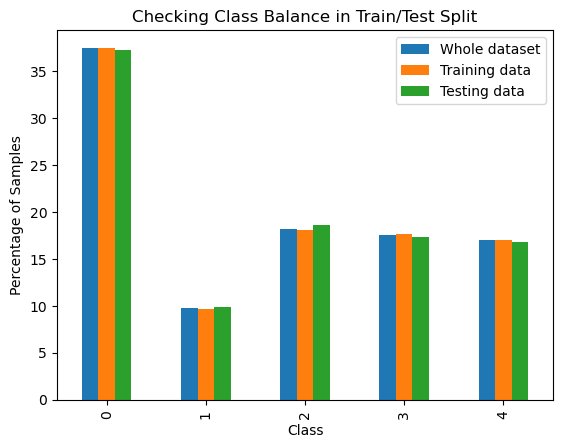

In [10]:
strat_y = (y.groupby('Class').value_counts())/len(y.index)*100
#print("The class balance by percentage for the WHOLE dataset is:\n", strat_y)

verify_strat_train = (y_train.groupby('Class').value_counts())/len(y_train.index)*100
#print("\nThe class balance by percentage for the TRAINING data is:\n", verify_strat_train)

verify_strat_test = (y_test.groupby('Class').value_counts())/len(y_test.index)*100
#print("\nThe class balance by percentage for the TEST data is:\n", verify_strat_test)

df = pd.DataFrame({'Whole dataset': strat_y, 'Training data': verify_strat_train, 
                   'Testing data': verify_strat_test})
ax = df.plot.bar()
ax.set_title('Checking Class Balance in Train/Test Split')
ax.set_ylabel('Percentage of Samples');

Stratification has been preserved in the training and testing data.

### 2.7.2 Modeling with Logistic Regression
<a id='2.7.2_Modeling_with_Logistic_Regression'></a>
I'll begin with just PCA and Logistic Regression in my pipeline.

In [11]:
# Create a pipeline with PCA and Logistic Regression
steps = [('pca', PCA(n_components=7)),
         ('clf', LogisticRegression(max_iter = 5000, multi_class='auto'))]
pipe_lr = Pipeline(steps)

pipe_lr.fit(X_train, y_train.values.ravel())
          
y_pred_test_lr = pipe_lr.predict(X_test)
y_pred_train_lr = pipe_lr.predict(X_train)

In [12]:
# Print the classification report for the training data
print("Train set classification report:\n", classification_report(y_train, y_pred_train_lr))

Train set classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        62
           2       1.00      1.00      1.00       116
           3       1.00      1.00      1.00       113
           4       1.00      1.00      1.00       109

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640



In [13]:
# Print the classification report for the testing data
print("Test set classification report:\n", classification_report(y_test, y_pred_test_lr))

Test set classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        30
           3       1.00      0.96      0.98        28
           4       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



The baseline model performs well.  The model performs perfectly for all classes in the training data so overfitting is a concern.  The testing data, however, performs almost as well.  The imbalanced data does not appear to be a huge issue at this point because the model predicts the majority class with an f1-score of 0.99 and the smallest minority class with an f1-score of 1.00.  

PCA with 7 principal components seems to be sufficient for prediction.

This model performs well but common practice is to scale the data before implementing PCA, so I will try that now to see if it improves the model performance.

In [14]:
# Create a pipeline with StandardScaler, PCA, and Logistic Regression
steps = [('scaler', StandardScaler()),
         ('pca', PCA(n_components=7)),
         ('clf', LogisticRegression(max_iter = 5000, multi_class='auto'))]

pipe_scaled_lr = Pipeline(steps)

pipe_scaled_lr.fit(X_train, y_train.values.ravel())
          
y_pred_test_scaled_lr = pipe_scaled_lr.predict(X_test)
y_pred_train_scaled_lr = pipe_scaled_lr.predict(X_train)

In [15]:
# Print the classification report for the training data
print("Train set classification report:\n", classification_report(y_train, y_pred_train_scaled_lr))

Train set classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        62
           2       1.00      1.00      1.00       116
           3       1.00      1.00      1.00       113
           4       1.00      1.00      1.00       109

    accuracy                           1.00       640
   macro avg       1.00      1.00      1.00       640
weighted avg       1.00      1.00      1.00       640



In [16]:
# Print the classification report for the testing data
print("Test set classification report:\n", classification_report(y_test, y_pred_test_scaled_lr))

Test set classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.88      0.93        16
           2       1.00      1.00      1.00        30
           3       0.93      0.93      0.93        28
           4       1.00      1.00      1.00        27

    accuracy                           0.98       161
   macro avg       0.98      0.96      0.97       161
weighted avg       0.98      0.98      0.97       161



Prediction of the training data is still 100% accurate but interestingly, overall model performane on the testing data declines when adding the scaler.  Precision is reduced for the majority class and recall is reduced for the smallest of the minority classes.  Additionally, both precision and recall are reduced for class 3.  With the scaler inline, my primary performance metric, f1-score macro avg, falls from 0.99 to 0.97. 

I'll plot the first two principal components of pca with and without scaling to see how the classes look.

In [17]:
y_numpy = y.to_numpy()

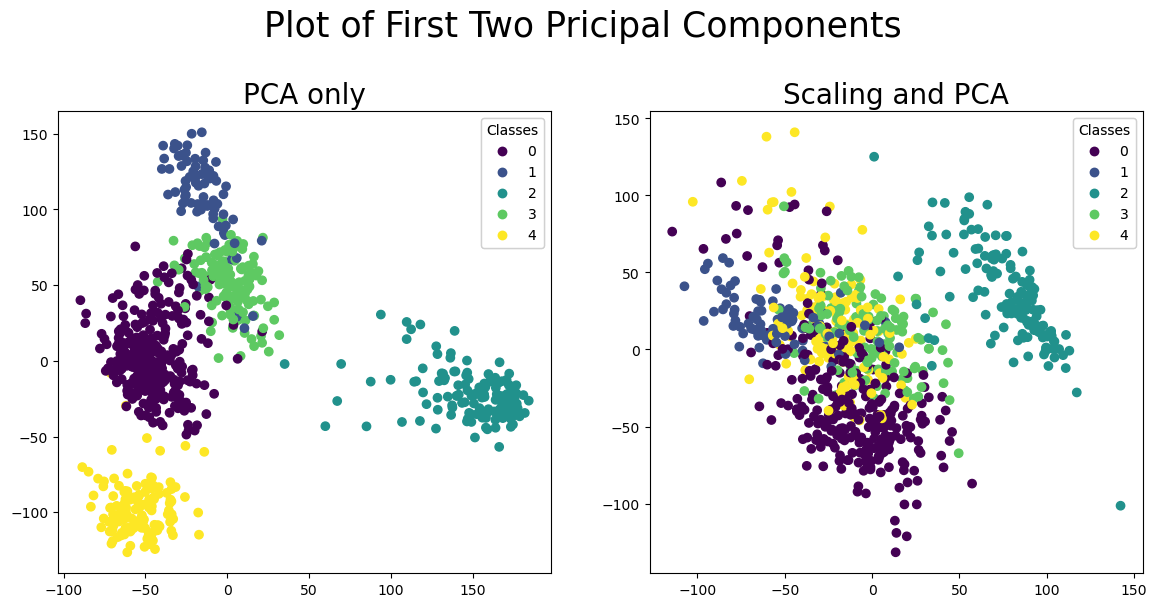

In [18]:
# PCA only
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X)

fig, ax = plt.subplots(1,2,figsize=(14,6))
fig.suptitle("Plot of First Two Pricipal Components", fontsize=25, y=1.05)

plot = ax[0].scatter(X_pca[:,0], X_pca[:,1], c=y_numpy)
ax[0].set_title("PCA only", fontsize=20)
legend0 = ax[0].legend(*plot.legend_elements(), title="Classes")
ax[0].add_artist(legend0)

# PCA with scaler
steps = [('scaler', StandardScaler()),
         ('pca', PCA(n_components=7))]

pipe = Pipeline(steps)
X_pca_scaled = pipe.fit_transform(X)

ax[1].scatter(X_pca_scaled[:,0], X_pca_scaled[:,1], c=y_numpy)
ax[1].set_title("Scaling and PCA", fontsize=20)
legend1 = ax[1].legend(*plot.legend_elements(), title="Classes")
ax[1].add_artist(legend1)

plt.show()


The classes are far better defined when pca is performed without scaling the data first.  I'll look at the confusion matrix to explore further.

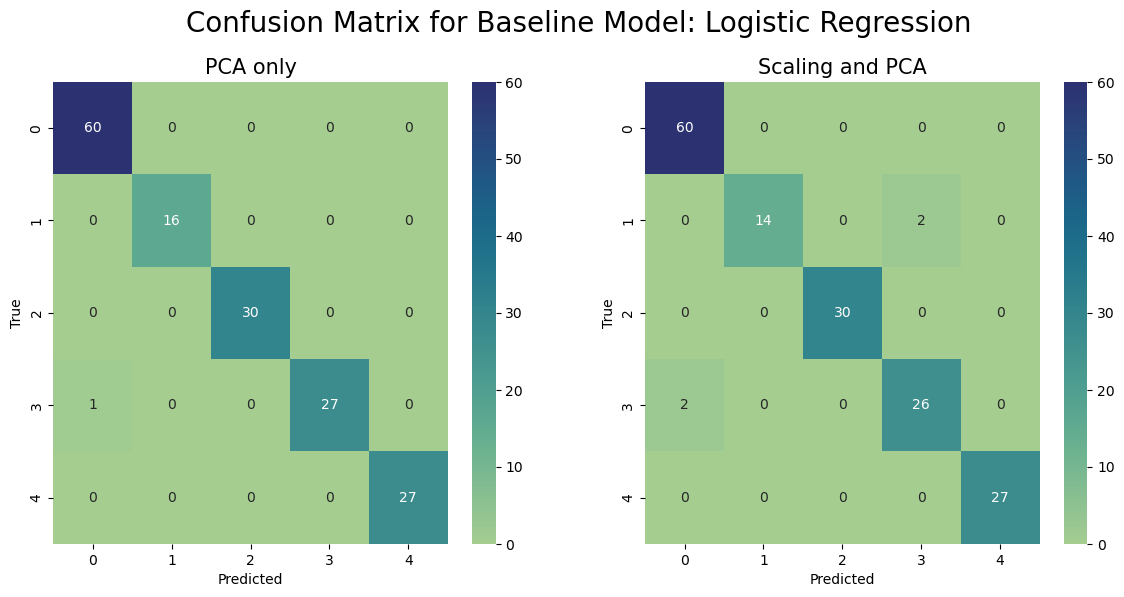

In [19]:
# Create confusion matrix for logistic regression model
multilabel_confusion_matrix_not_scaled = confusion_matrix(y_test, y_pred_test_lr)
multilabel_confusion_matrix_scaled = confusion_matrix(y_test, y_pred_test_scaled_lr)

# Plot the confusion matrix
fig, ax = plt.subplots(1,2,figsize=(14,6))
fig.suptitle("Confusion Matrix for Baseline Model: Logistic Regression", fontsize=20, y=1.0)

sns.heatmap(multilabel_confusion_matrix_not_scaled, cmap='crest', annot=True, ax=ax[0])
ax[0].set_title("PCA only", fontsize=15)
ax[0].set(ylabel="True", xlabel="Predicted")

sns.heatmap(multilabel_confusion_matrix_scaled, cmap='crest', annot=True, ax=ax[1])
ax[1].set_title("Scaling and PCA", fontsize=15)
ax[1].set(ylabel="True", xlabel="Predicted");

The confusion matrix confirms PCA without scaling to be the better predictor.  I'll compare the explained variance for further insight.

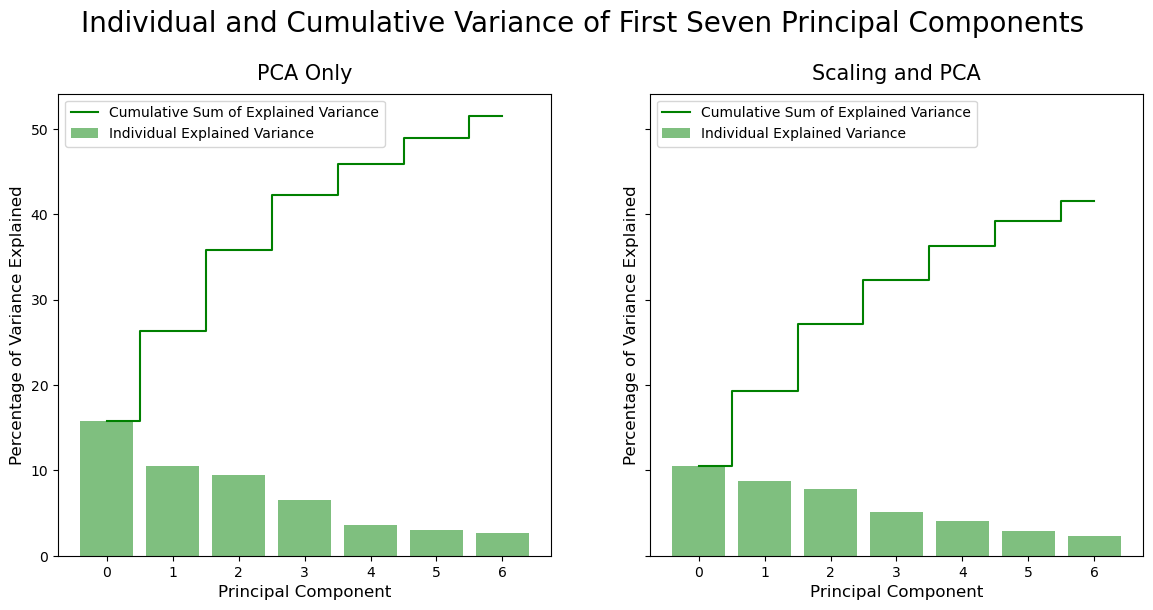

In [20]:
Xstd = StandardScaler().fit_transform(data)
pca_Xstd = PCA(n_components=7)
pca_Xstd.fit_transform(Xstd)

# Find individual explained variance and then change to percent
exp_var_pca_Xstd = pca_Xstd.explained_variance_ratio_
exp_var_pca_perc_Xstd = exp_var_pca_Xstd*100

# Find cumulative explained variance and then change to percent
cum_sum_Xstd = np.cumsum(exp_var_pca_Xstd)
cum_sum_perc_Xstd=cum_sum_Xstd*100

# Plot the individual and cumulative variance results
fig, ax = plt.subplots(1,2,figsize=(14,6), sharey=True)
fig.suptitle("Individual and Cumulative Variance of First Seven Principal Components", fontsize=20, y=1.02)

ax[0].bar(range(0,len(exp_var_pca_perc)), exp_var_pca_perc, alpha=0.5, color = 'g', label='Individual Explained Variance')
ax[0].step(range(0,len(cum_sum_perc)), cum_sum_perc, where='mid',color = 'g', label='Cumulative Sum of Explained Variance')
ax[0].set_title('PCA Only', pad=10, fontsize=15)
ax[0].set_ylabel('Percentage of Variance Explained', fontsize=12)
ax[0].set_xlabel('Principal Component', fontsize=12)
ax[0].legend(loc='upper left')

ax[1].bar(range(0,len(exp_var_pca_perc_Xstd)), exp_var_pca_perc_Xstd, alpha=0.5, color = 'g', label='Individual Explained Variance')
ax[1].step(range(0,len(cum_sum_perc_Xstd)), cum_sum_perc_Xstd, where='mid',color = 'g', label='Cumulative Sum of Explained Variance')
ax[1].set_title('Scaling and PCA', pad=10, fontsize=15)
ax[1].set_ylabel('Percentage of Variance Explained', fontsize=12)
ax[1].set_xlabel('Principal Component', fontsize=12)
ax[1].legend(loc='upper left')

plt.show();


The explained variance is greater for PCA without scaling over the first seven components.  This is an interesting case where it seems advisable to proceed without scaling; so that is what I will do.

## 2.8 Cross Validation
<a id='2.8_Cross_Validation'></a>
The model above is fitting 100% of the training data and that is not necessarily a good thing.  I will cross validate to see if the results remain consistent through multiple folds.  Using StratifyKFold will preserve the balance of the classes in each fold.

In [21]:
# Use StratifyKFold for cross validation
k = 5
cv = StratifiedKFold(n_splits=k, random_state=4, shuffle=True)
scores = cross_val_score(pipe_lr, X_train, y_train.values.ravel(), scoring='f1_macro', cv=cv)


In [22]:
print("Scores for each fold (PCA, Logistic Regression, StratifiedKFold)\n")
for i in range (0,k):
    print('Fold number: %d, F1_macro_avg: %.3f' %(i, scores[i]))

Scores for each fold (PCA, Logistic Regression, StratifiedKFold)

Fold number: 0, F1_macro_avg: 1.000
Fold number: 1, F1_macro_avg: 1.000
Fold number: 2, F1_macro_avg: 0.987
Fold number: 3, F1_macro_avg: 0.991
Fold number: 4, F1_macro_avg: 1.000


It appears the model's excellent predictions in the training data were not a fluke - they are either perfect or nearly perfect through all folds.  I will explore overfitting more when fine tuning the baseline model in the next notebook.

## 2.9 Save Data
<a id='2.9_Save_Data'></a>

In [23]:
X.to_csv("X.csv", index=False)

In [24]:
#np.savetxt('y.txt', y)
y.to_csv("y.csv", index=False)

In [25]:
X_train.to_csv("X_train.csv", index=False)

In [26]:
X_test.to_csv("X_test.csv", index=False)

In [27]:
#np.savetxt('y_train.txt', y_train)
y_train.to_csv("y_train.csv", index=False)

In [28]:
#np.savetxt('y_test.txt', y_test)
y_test.to_csv("y_test.csv", index=False)

## 2.10 Summary
<a id='2.10_Summary'></a>

I have set the landing dimension at 7 and established the primary performance metric will be the macro averaged f1 score.  I've completed the baseline model and determined it will include PCA without scaling.  

In the next notebook, I will fine tune the baseline model and I will explore other model choices to see which has the best prediction power for this project.